In [1]:
# Imports
import sys
sys.path.append("Program")

import datetime as dt
from fundamentals import *
from helper_functions import get_current_date, get_df, get_volume5m_data, generate_end_dates, merge_stocks, stock_market
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from plot import *
from scipy.stats import linregress, pearsonr, ttest_ind
from stock_screener import check_conds_tech, get_stock_info, stoploss_target
from technicals import *

In [2]:
# Start of the program
start = dt.datetime.now()

# Variables
HKEX_all = False
NASDAQ_all = True
period_hk = 60 # Period for HK stocks
period_us = 252 # Period for US stocks
RS = 90
factors = [1, 1, 1]
backtest = False

# Index
index_name = "^GSPC"
index_dict = {"^HSI": "HKEX", "^GSPC": "S&P 500", "^IXIC": "NASDAQ Composite"}

# Get the infix
infix = get_infix(index_name, index_dict, NASDAQ_all)

# Get the current date
current_date = get_current_date(start, index_name)

# Define the result folder
result_folder = "Result"

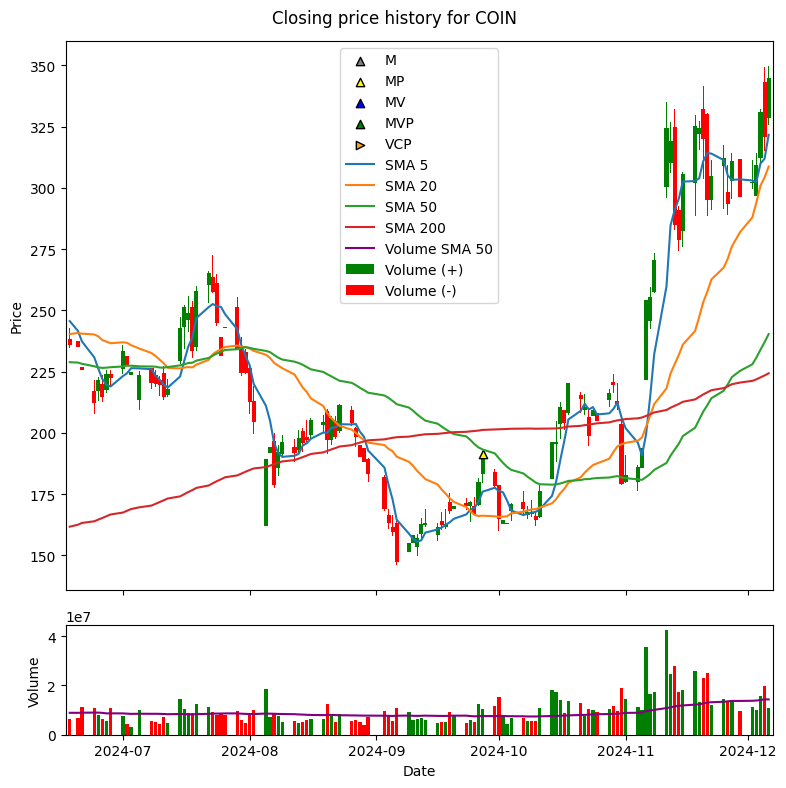

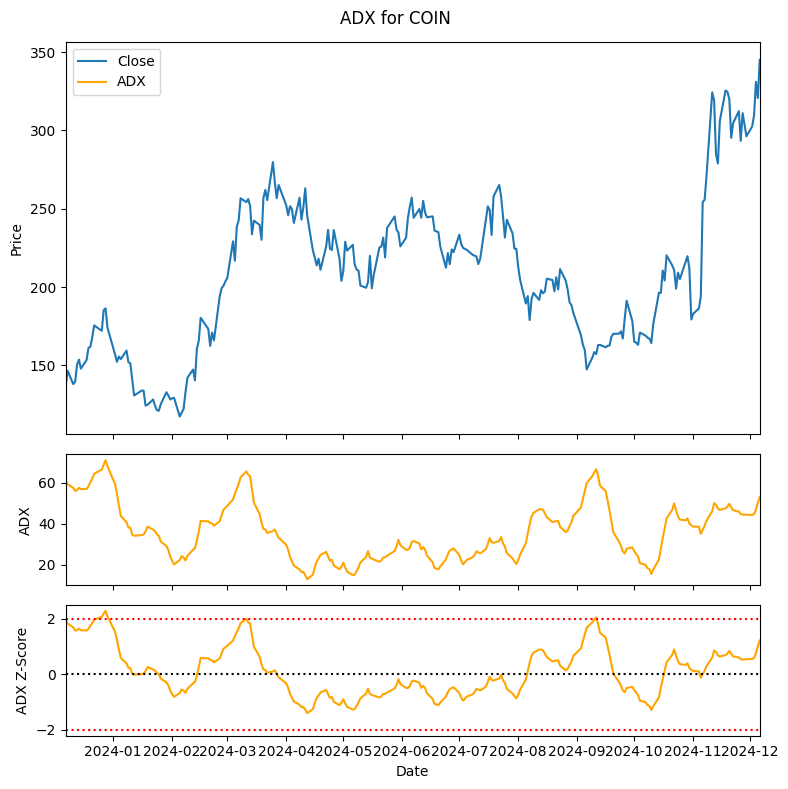

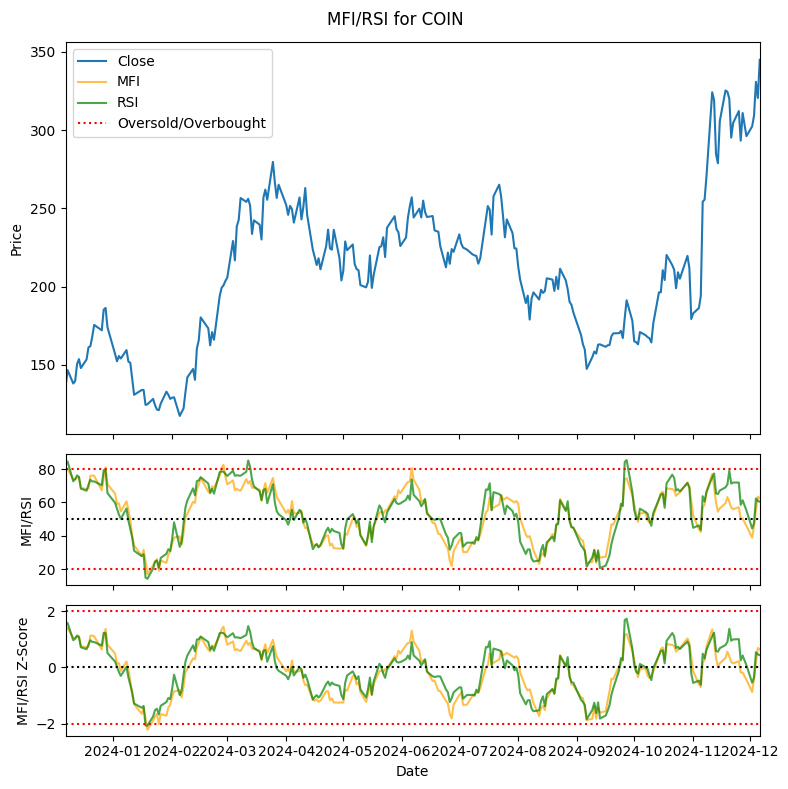

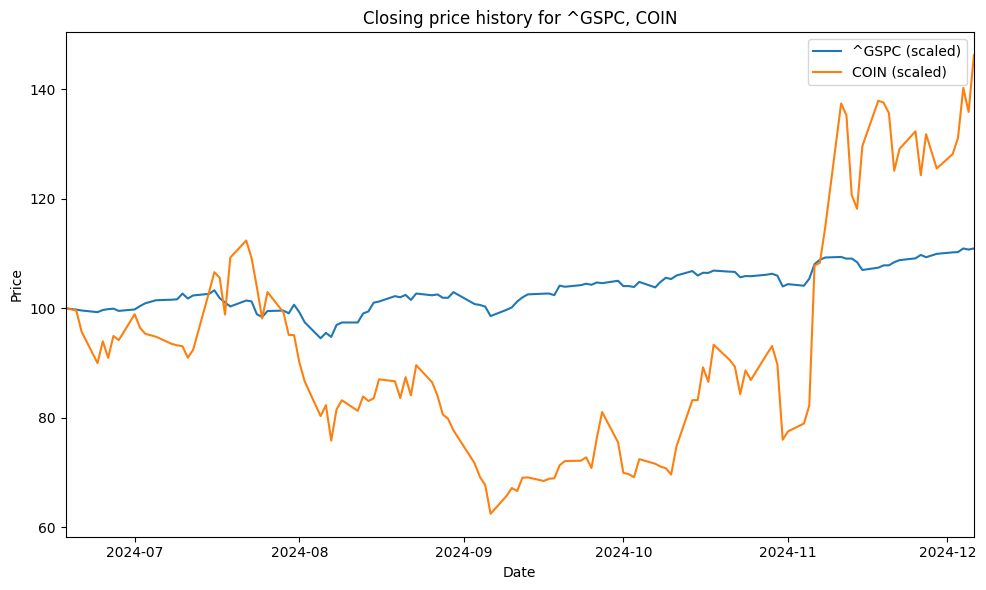

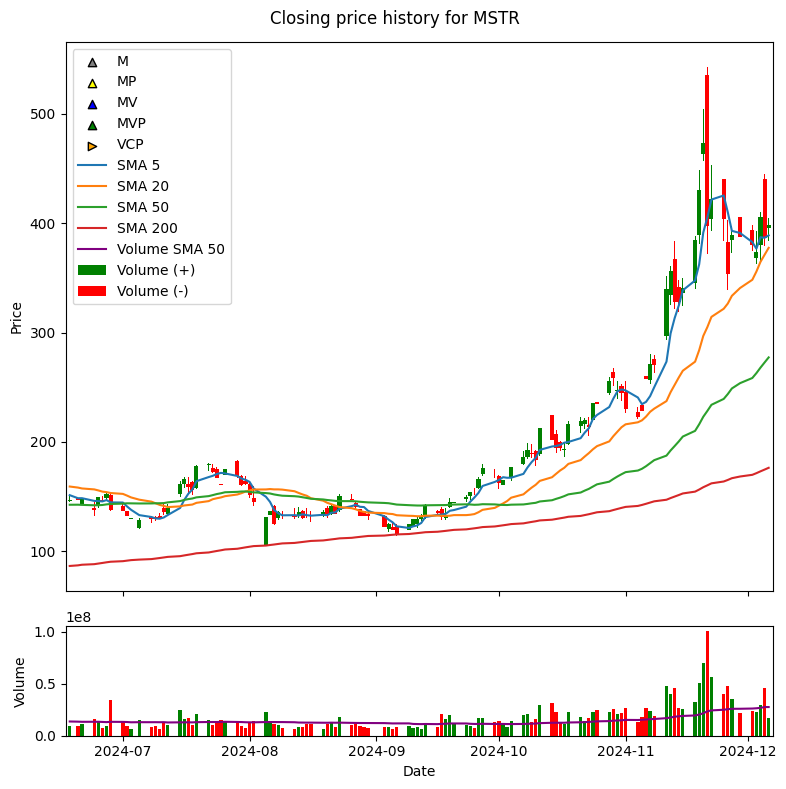

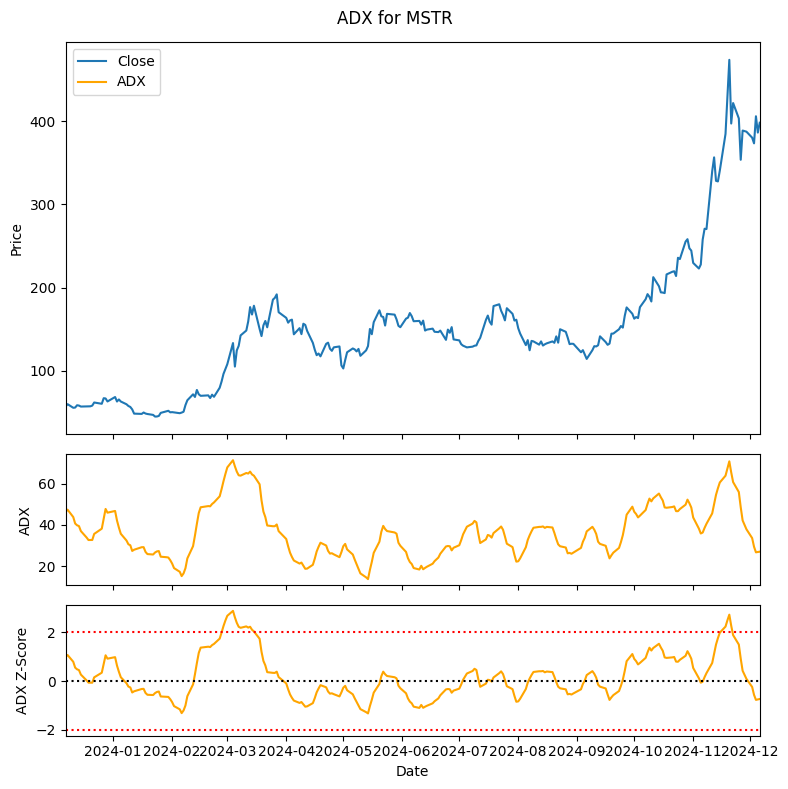

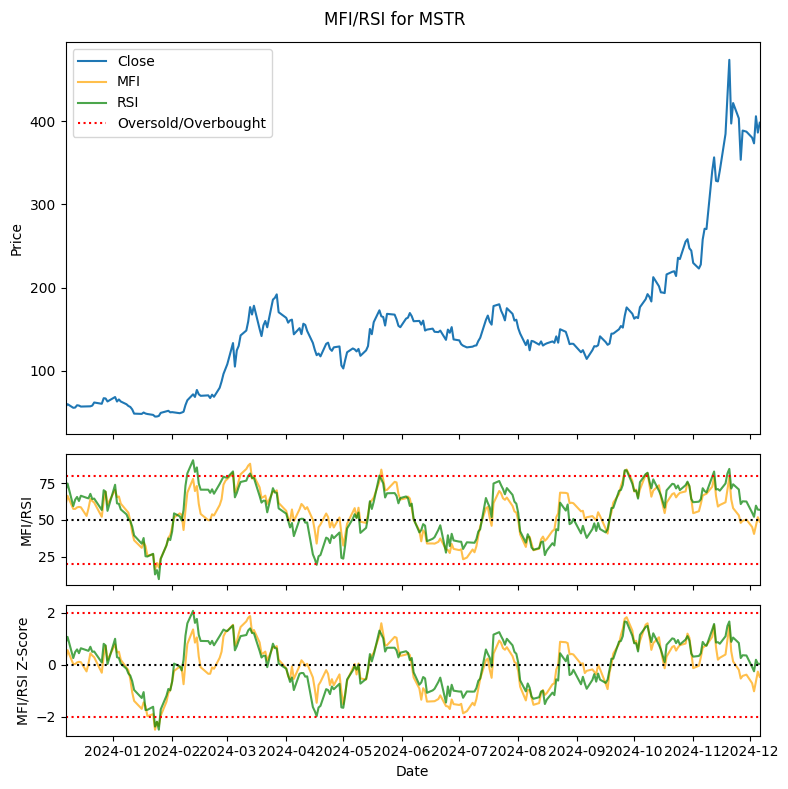

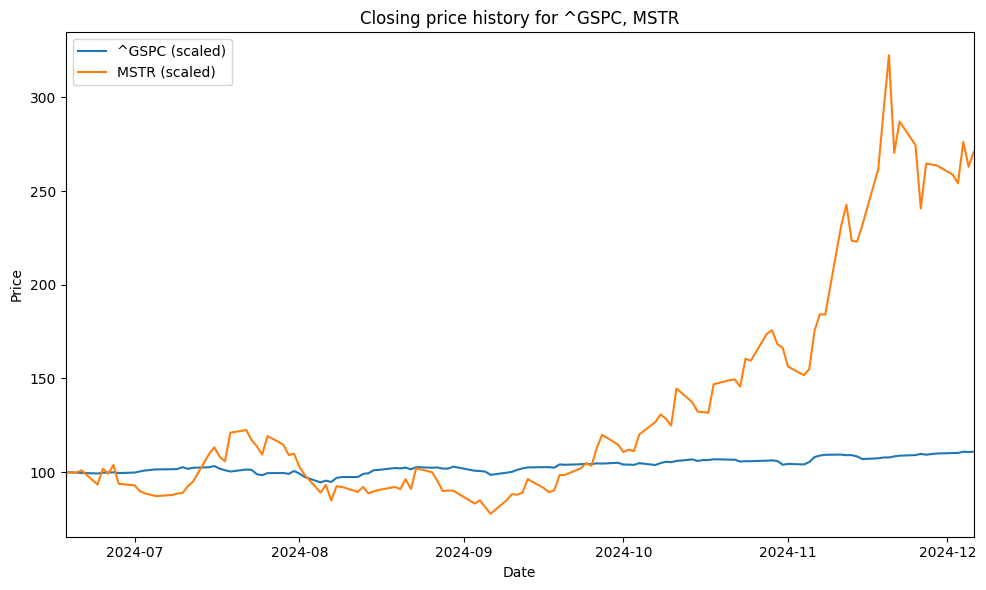

In [3]:
# Choose the stocks
stocks = ["COIN", "MSTR"]
for stock in stocks:
    df = get_df(stock, current_date)
    plot_close(stock, df)
    plot_ADX(stock, df)
    plot_MFI_RSI(stock, df)
    if stock.endswith(".HK"):
        plot_stocks(["^HSI", stock], current_date)
    else:
        plot_stocks(["^GSPC", stock], current_date)

In [ ]:
# Get the stop loss and target price of a stock
stock = "VRT"
size = 10
industry = "Industrial/Electricity"
entry_date = "2024-12-06"
entry_date_fmt = dt.datetime.strptime(entry_date, "%Y-%m-%d").strftime("%d-%m-%y")
df = get_df(stock, current_date)
current_close = df["Close"].iloc[-1]
df["SMA 20"] = SMA(df, 20)
entry = df["SMA 20"].iloc[-1]
entry = 126.238
stoploss, stoploss_pct, target, target_pct = stoploss_target(stock, entry, entry_date)
print(f"Plan for {stock}.")
print(f"Current close: {round(current_close, 2)}.")
print(f"{stock} {size}% ({industry}) Entry {entry} ({entry_date_fmt}) SL {stoploss} ({stoploss_pct}%) TP {target} ({target_pct}%)")

In [ ]:
stock = "WLFC"
df = get_df(stock, current_date)
df = get_volatility(df)
df = ADX(df)
df = MVP_VCP(df)
df = MFI(df)
df = RSI(df)
df = calculate_ZScore(df, ["ADX", "MFI", "RSI"], 252)
df["Row Number"] = range(1, len(df) + 1)
df = calculate_ndays_return(df, np.arange(5, 65, 5))
df = calculate_ndays_return(df, 1)
df["SMA 20"] = SMA(df, 20)
df["Close/SMA 20"] = df["Close"] / df["SMA 20"]

In [ ]:
# Filter the data after breakout
csv_date = (dt.datetime.strptime(current_date, "%Y-%m-%d") - relativedelta(years=5)).strftime("%Y-%m-%d")
df_filter = df[df.index >= "2024-05-02"]
df_inlier, df_outlier = filter_df_outlier(df_filter, "Close/SMA 20", -1, greater=False)

# Remove dates with too few separation
rows = [df_outlier["Row Number"].iloc[0]]
for row in df_outlier["Row Number"][1:]:
    if row - rows[-1] >= 0:
        rows.append(row)
df_outlier = df_outlier[df_outlier["Row Number"].isin(rows)]

In [ ]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True)

# Drop NaN values once for efficiency
filtered_index = df_filter.dropna().index
filtered_data = df_filter.dropna()

# Plot the first subplot
ax1.plot(filtered_index, filtered_data["Close"])
ax1.set_ylabel("Price")

# Set the x limit of the first subplot
buffer = relativedelta(days=1)
ax1.set_xlim(filtered_index[0] - buffer, filtered_index[-1] + buffer)

# Plot the second subplot
ax2.plot(filtered_index, filtered_data["Close/SMA 20"])
ax2.set_ylabel("Close/SMA 20")

# Plot the third subplot
ax3.plot(filtered_index, filtered_data["Close/SMA 20 Z-Score"], color="red")
ax3.set_ylabel("Close/SMA 20 Z-Score")

# Add a red dotted line at y=2
ax3.axhline(y=2, color="red", linestyle="dotted")

# Add a red dotted line at y=-2
ax3.axhline(y=-2, color="red", linestyle="dotted")

# Set the x label and title
plt.xlabel("Date")
plt.suptitle(f"Close/SMA 20 of {stock}")

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"Result/Figure/closesma20{stock}.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
return_20_inlier = df_inlier["20 Days Return (%)"].dropna()
return_20_outlier = df_outlier["20 Days Return (%)"].dropna()
plot_ndays_return(stock, df_filter.dropna(), 1, save=True)
plot_ndays_return(stock, df_inlier.dropna(), 20, infix="inlier", save=True)
plot_ndays_return(stock, df_outlier.dropna(), 20, infix="outlier", save=True)

In [ ]:
print(len(return_20_inlier), len(return_20_outlier))

In [ ]:
# Perform a two-sample t-test
t_stat, p_value = ttest_ind(return_20_outlier, return_20_inlier, alternative="greater")
print(t_stat, p_value)

In [ ]:
# Variables
end_date1 = "2024-09-12"
end_date2 = "2024-10-07"
period1 = 252
period2 = 20

# Get the infix
hsi_infix = get_infix("^HSI", index_dict, NASDAQ_all)
sp500_infix = get_infix("^GSPC", index_dict, NASDAQ_all)

# Get the list of stocks
hsi_stocks = stock_market(current_date, current_date, "^HSI", HKEX_all, NASDAQ_all)
sp500_stocks = stock_market(current_date, current_date, "^GSPC", HKEX_all, NASDAQ_all)

# Get the price data of the index
hsi_df = get_df("^HSI", current_date)
sp500_df = get_df("^GSPC", current_date)
merged_df = longshortRS(sp500_stocks, sp500_df, "^GSPC", index_dict, NASDAQ_all, current_date, end_date1, end_date2, period1, period2, result_folder, sp500_infix, volume_filter=500)

# Plot the long and short term RS
plot_longshortRS(merged_df, end_date1, end_date2)

In [ ]:
# Define the end dates
end_dates = generate_end_dates(3, current_date, interval="1w")

# Compare the long and short term RS
rs_slopes, r_squareds, end_dates2 = compare_longshortRS(sp500_stocks, sp500_df, "^GSPC", index_dict, NASDAQ_all, current_date, end_dates, period1, period2, result_folder, hsi_infix)

In [ ]:
# Plot the comparison between long and short term RS
plot_compare_longshortRS(sp500_df, "^GSPC", rs_slopes, r_squareds, end_dates, end_dates2)

In [ ]:
show = 252 * 3
stocks = ["GC=F", "SI=F", "HG=F"]
metal_df = merge_stocks(stocks, current_date)
metal_df["Gold/Silver Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (SI=F)"]
metal_df["Gold/Copper Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (HG=F)"]
metal_df = calculate_ZScore(metal_df, ["Gold/Silver Ratio", "Gold/Copper Ratio"], 252)

# Restrict the dataframe
metal_df = metal_df[- show:]

# Create a figure with three subplots, one for the metal prices, one for the ratios, one for the ratios z-score
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True)

# Plot the metal prices on the first subplot
close_goldfirst = metal_df["Close (GC=F)"].iloc[0]
close_silverfirst = metal_df["Close (SI=F)"].iloc[0]
close_copperfirst = metal_df["Close (HG=F)"].iloc[0]
ax1.plot(100 / close_goldfirst * metal_df["Close (GC=F)"], label="Gold (scaled)", color="gold")
ax1.plot(100 / close_silverfirst * metal_df["Close (SI=F)"], label="Silver (scaled)", color="silver")
ax1.plot(100 / close_copperfirst * metal_df["Close (HG=F)"], label="Copper (scaled)", color="peru")

# Set the label of the first subplot
ax1.set_ylabel("Price")

# Set the x limit of the first subplot
ax1.set_xlim(metal_df.index[0], metal_df.index[-1])

# Plot the ratios on the second subplot
goldsilver_ratio_first = metal_df["Gold/Silver Ratio"].iloc[0]
goldcopper_ratio_first = metal_df["Gold/Copper Ratio"].iloc[0]
ax2.plot(100 / goldsilver_ratio_first * metal_df["Gold/Silver Ratio"], color="silver")
ax2.plot(100 / goldcopper_ratio_first * metal_df["Gold/Copper Ratio"], color="peru")

# Set the y label of the second subplot
ax2.set_ylabel("Ratio wrt Gold")

# Plot the ratios z-score on the third subplot
ax3.plot(metal_df["Gold/Silver Ratio Z-Score"], color="silver")
ax3.plot(metal_df["Gold/Copper Ratio Z-Score"], color="peru")
ax3.axhline(y=2, linestyle="dotted", label="Undervalued", color="green")
ax3.axhline(y=-2, linestyle="dotted", label="Overvalued", color="red")

# Set the y label of the third subplot
ax3.set_ylabel("Ratio z-score")

# Set the x label
plt.xlabel("Date")

# Set the title
plt.suptitle(f"Metal prices comparison")

# Combine the legends and place them at the top subplot
handles, labels = ax1.get_legend_handles_labels()
handles += ax3.get_legend_handles_labels()[0]
labels += ax3.get_legend_handles_labels()[1]
ax1.legend(handles, labels)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig("Result/Figure/metalcompare.png", dpi=300)    

# Show the plot
plt.show()